In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

from config import PROJECT_ROOT, load_config, setup_project_paths

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jorgesarmiento/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgesarmiento/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jorgesarmiento/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
setup_project_paths()
config = load_config()

In [3]:
NLTK_STOPWORDS = set(nltk.corpus.stopwords.words('english'))

In [4]:
FOOD_DATA_PATH = PROJECT_ROOT / config.data.raw_data_path / "food"
FOOD_VOCAB_PATH = PROJECT_ROOT / config.data.cleaned_data_path / "food"
if not FOOD_VOCAB_PATH.exists():
    FOOD_VOCAB_PATH.mkdir(parents=True, exist_ok=True)

print(f"Input path: {FOOD_DATA_PATH}")
print(f"Vocabulary path: {FOOD_VOCAB_PATH}")

Input path: /Users/jorgesarmiento/workspace/personal/audio_reprompt/data/raw/food
Vocabulary path: /Users/jorgesarmiento/workspace/personal/audio_reprompt/data/cleaned/food


## Daily Food Nutrition Dataset

In [12]:
# Cargar el dataset de nutrición diaria de alimentos
df_daily_food_nutrition = pd.read_csv(FOOD_DATA_PATH / "daily_food_nutrition_dataset.csv", usecols=["Food_Item", "Category", "Meal_Type"])
df_daily_food_nutrition.head()

,Food_Item,Category,Meal_Type
0,Eggs,Meat,Lunch
1,Apple,Fruits,Lunch
2,Chicken Breast,Meat,Breakfast
3,Banana,Fruits,Snack
4,Banana,Fruits,Lunch


Category
Dairy         1460
Fruits        1453
Beverages     1445
Snacks        1432
Meat          1418
Vegetables    1408
Grains        1384
Name: count, dtype: int64


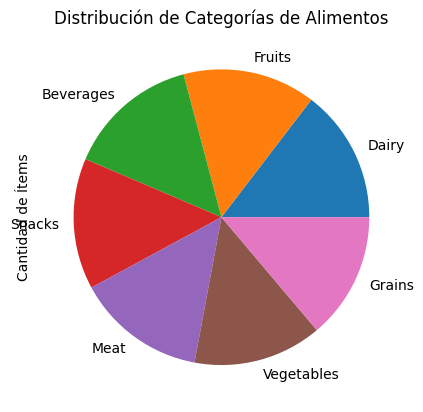

Meal_Type
Breakfast    2559
Dinner       2503
Lunch        2487
Snack        2451
Name: count, dtype: int64


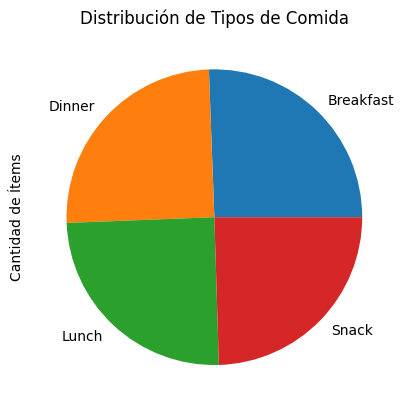

In [17]:
# Visualizar la distribución de categorías de alimentos y el tipo de comida
category_counts = df_daily_food_nutrition['Category'].value_counts()
print(category_counts)
category_counts.plot(kind='pie', title='Distribución de Categorías de Alimentos')
plt.ylabel('Cantidad de Ítems')
plt.show()

meal_type_counts = df_daily_food_nutrition['Meal_Type'].value_counts()
print(meal_type_counts)
meal_type_counts.plot(kind='pie', title='Distribución de Tipos de Comida')
plt.ylabel('Cantidad de Ítems')
plt.show()

In [18]:
# Crear un vocabulario único de términos de alimentos agrupados por categoría y tipo de comida
unique_food_terms = df_daily_food_nutrition.groupby(['Category', 'Meal_Type'])['Food_Item'].unique().reset_index()
unique_food_terms.rename(columns={'Food_Item': 'Unique_Food_Terms'}, inplace=True)
unique_food_terms.head()

,Category,Meal_Type,Unique_Food_Terms
0,Beverages,Breakfast,"[Water, Green Tea, Milkshake, Coffee, Orange J..."
1,Beverages,Dinner,"[Orange Juice, Coffee, Milkshake, Water, Green..."
2,Beverages,Lunch,"[Milkshake, Coffee, Green Tea, Water, Orange J..."
3,Beverages,Snack,"[Orange Juice, Water, Green Tea, Milkshake, Co..."
4,Dairy,Breakfast,"[Cheese, Butter, Paneer, Milk, Yogurt]"


In [29]:
# Guardar el vocabulario limpio en un archivo CSV
unique_food_terms.to_csv(FOOD_VOCAB_PATH / "daily_food_terms_vocabulary.csv", index=False)

## Recipes dataset

In [5]:
df_recipes = pd.read_csv(FOOD_DATA_PATH / "recipes.csv", usecols=["Name", "RecipeInstructions"])
df_recipes.head()

,Name,RecipeInstructions
0,Low-Fat Berry Blue Frozen Dessert,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,Biryani,"c(""Soak saffron in warm milk for 5 minutes and..."
2,Best Lemonade,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,Carina's Tofu-Vegetable Kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,Cabbage Soup,"c(""Mix everything together and bring to a boil..."


In [6]:
df_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Name                522517 non-null  object
 1   RecipeInstructions  522517 non-null  object
dtypes: object(2)
memory usage: 8.0+ MB


In [6]:
recipe = df_recipes.iloc[0]
print(f"Recipe Name: {recipe['Name']}")
print(f"Instructions: {recipe['RecipeInstructions']}")

instructions = recipe['RecipeInstructions']
# Eliminar el prefijo y sufijo c(), las comillas y espacios innecesarios
instructions = instructions.strip('c()')
# Eliminar comillas y espacios innecesarios
instructions = instructions.replace('"', '').replace("\n", " ").strip()
print(f"Cleaned Instructions: {instructions}")
# Convertir a lista de instrucciones a partir de este formato c("Toss 2 cups berries with sugar.", "Let stand for 45 minutes, stirring occasionally.", "Transfer berry-sugar mixture to food processor.")
instructions_list = instructions.split('.,')
instructions_list = [instr for instr in instructions_list]
print("Instructions List:")
for instr in instructions_list:
    print(f"- {instr}")


Recipe Name: Low-Fat Berry Blue Frozen Dessert
Instructions: c("Toss 2 cups berries with sugar.", "Let stand for 45 minutes, stirring occasionally.", "Transfer berry-sugar mixture to food processor.", "Add yogurt and process until smooth.", "Strain through fine sieve. Pour into baking pan (or transfer to ice cream maker and process according to manufacturers' directions). Freeze uncovered until edges are solid but centre is soft.  Transfer to processor and blend until smooth again.", "Return to pan and freeze until edges are solid.", "Transfer to processor and blend until smooth again.", 
"Fold in remaining 2 cups of blueberries.", "Pour into plastic mold and freeze overnight. Let soften slightly to serve.")
Cleaned Instructions: Toss 2 cups berries with sugar., Let stand for 45 minutes, stirring occasionally., Transfer berry-sugar mixture to food processor., Add yogurt and process until smooth., Strain through fine sieve. Pour into baking pan (or transfer to ice cream maker and proces

In [7]:
# funcion para limpiar las instrucciones de receta
def clean_recipe_instructions(instructions):
    instructions = instructions.strip('c()')
    instructions = instructions.replace('"', '').replace("\n", " ").replace(".,", "*").strip()
    instructions = instructions.split('*')
    return instructions

In [8]:
def tokenize_instructions(instructions_list):
    tokenized_instructions = []
    for instructions_text in instructions_list:
        tokens = word_tokenize(instructions_text)
        tokens = [token for token in tokens if token not in NLTK_STOPWORDS and token.isalpha()]
        tokenized_instructions.append(tokens)
    return tokenized_instructions

In [9]:
# transformar las instrucciones de receta en el dataframe
df_recipes['Cleaned_Instructions'] = df_recipes['RecipeInstructions'].apply(clean_recipe_instructions)
df_recipes['Tokenized_Instructions'] = df_recipes['Cleaned_Instructions'].apply(tokenize_instructions)
df_recipes.head()

,Name,RecipeInstructions,Cleaned_Instructions,Tokenized_Instructions
0,Low-Fat Berry Blue Frozen Dessert,"c(""Toss 2 cups berries with sugar."", ""Let stan...","[Toss 2 cups berries with sugar, Let stand fo...","[[Toss, cups, berries, sugar], [Let, stand, mi..."
1,Biryani,"c(""Soak saffron in warm milk for 5 minutes and...",[Soak saffron in warm milk for 5 minutes and p...,"[[Soak, saffron, warm, milk, minutes, puree, b..."
2,Best Lemonade,"c(""Into a 1 quart Jar with tight fitting lid, ...","[Into a 1 quart Jar with tight fitting lid, pu...","[[Into, quart, Jar, tight, fitting, lid, put, ..."
3,Carina's Tofu-Vegetable Kebabs,"c(""Drain the tofu, carefully squeezing out exc...","[Drain the tofu, carefully squeezing out exces...","[[Drain, tofu, carefully, squeezing, excess, w..."
4,Cabbage Soup,"c(""Mix everything together and bring to a boil...","[Mix everything together and bring to a boil, ...","[[Mix, everything, together, bring, boil], [Re..."


In [73]:
# Descartar la columna original de instrucciones
df_recipes.drop(columns=['RecipeInstructions'], inplace=True)

In [75]:
# Guardar el vocabulario limpio en un archivo CSV
df_recipes.to_csv(FOOD_VOCAB_PATH / "recipes_terms_vocabulary.csv", index=False)

## Food Nutrition dataset

In [81]:
# Cargar los siguientes datasets y unirlos en un solo vocabulario único de términos de alimentos
df_food_nutrition_1 = pd.read_csv(FOOD_DATA_PATH / "FOOD-DATA-GROUP1.csv", usecols=["food"])
df_food_nutrition_2 = pd.read_csv(FOOD_DATA_PATH / "FOOD-DATA-GROUP2.csv", usecols=["food"])
df_food_nutrition_3 = pd.read_csv(FOOD_DATA_PATH / "FOOD-DATA-GROUP3.csv", usecols=["food"])
df_food_nutrition_4 = pd.read_csv(FOOD_DATA_PATH / "FOOD-DATA-GROUP4.csv", usecols=["food"])
df_food_nutrition_5 = pd.read_csv(FOOD_DATA_PATH / "FOOD-DATA-GROUP5.csv", usecols=["food"])

# Unir todos los dataframes en uno solo
df_food_nutrition = pd.concat([df_food_nutrition_1, df_food_nutrition_2, df_food_nutrition_3, df_food_nutrition_4, df_food_nutrition_5], ignore_index=True)

# Eliminar duplicados
df_food_nutrition = df_food_nutrition.drop_duplicates(subset=["food"])
df_food_nutrition.head()

,food
0,cream cheese
1,neufchatel cheese
2,requeijao cremoso light catupiry
3,ricotta cheese
4,cream cheese low fat


In [83]:
# Guardar el vocabulario limpio en un archivo CSV
df_food_nutrition.to_csv(FOOD_VOCAB_PATH / "food_nutrition_vocabulary.csv", index=False)